## Limitações na Seleção de Conjuntos de Dados e a Importância da Validação Cruzada

#### Neste notebook observaremos como a escolha do conjunto treino e teste para calibração e validação de modelos pode ter um papel fundamental na performance do modelo. O método de validação cruzada (Cross-Validation, CV) será apresentado como uma forma mais criteriosa para estimar a real capacidade de generalização de modelos na predição de novos dados.

### Importando bibliotecas básicas de trabalho

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Para esta atividade, trabalharemos com uma amostra reduzida da base de dados de preços de casas em boston, disponível no scikitlearn. A redução desta base é uma tentativa de reproduzir um conjunto comumente encontrado em problemas reais do dia-a-dia de um cientista de dados, em que a qualidade e disponibilidade de dados é em muitos casos limitada.

### Importando a base de estudo

In [125]:
from sklearn.datasets import load_boston

In [126]:
boston = load_boston()

In [127]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### Após carregarmos a base completa, podemos gerar um sub-conjunto a partir do seguinte comando:

In [128]:
df = pd.concat([pd.DataFrame(boston.data, columns = boston.feature_names), 
                pd.DataFrame(boston.target, columns = ['MEDV'])], 
               axis = 1
              ).sample(100, random_state = 0).reset_index(drop = True)

### Análise da variável resposta

#### Em seguida, podemos avaliar a distribuição da variável resposta correspondente aos valores de propriedades (MEDV).

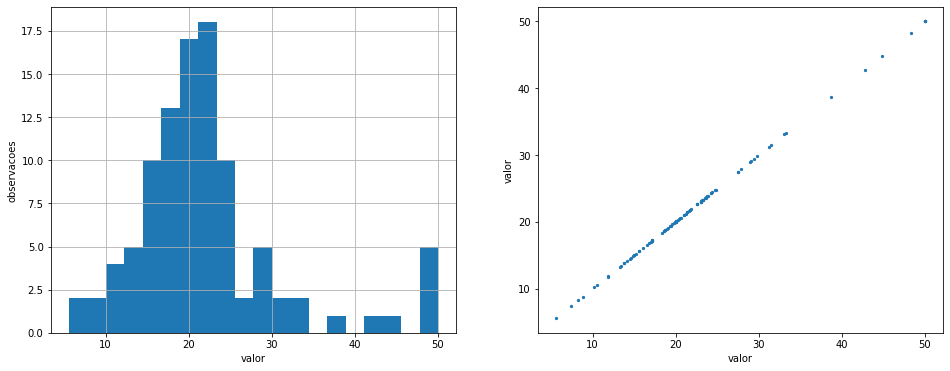

In [129]:
fig, ax = plt.subplots(1, 
                       2, 
                       figsize = (16, 6)
                      )
df['MEDV'].hist(bins = 20, 
                ax = ax[0]
               )
ax[0].set(xlabel = 'valor', 
          ylabel = 'observacoes'
         )
ax[1] = plt.scatter(df['MEDV'], 
                    df['MEDV'], 
                    s = 5
                   )
plt.xlabel('valor')
plt.ylabel('valor');

## Modelo Preditivo

#### Nesta etapa, vamos gerar rapidamente um modelo preditivo e avaliar sua performance. Como uma opção para problemas supervisionados de regressão, escolhemos para este exemplo o algorítmo de árvores de decisão.

In [130]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

Em seguida, podemos gerar uma função que gera e avalia modelos com o algoritmo selecionado. Como métrica de avaliação, escolhemos avaliar o erro médio absolute (absolute mean error, MAE).

In [131]:
def pred_price(df):
    # separando o conjunto total em conjunto treino e teste
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['MEDV'], axis=1), 
                                                        df['MEDV'], 
                                                        test_size = 0.3
                                                       )
    # definindo o modelo
    model = DecisionTreeRegressor()
    # otimizando os hiperparâmetros do modelo
    model.fit(X_train, y_train)
    # avaliando o modelo gerado
    y_pred = model.predict(X_test)
    return metrics.mean_absolute_error(y_test, y_pred)

#### Agora, com a nossa função concluída, vamos rodar o modelo:

In [132]:
pred_price(df)

4.0233333333333325

#### Talvez você tenha observado um valor muito diferente do apresentado acima. Vamos rodar o modelo novamente!

In [133]:
pred_price(df)

3.5

#### E novamente.

In [134]:
pred_price(df)

3.89

#### E uma última vez.

In [135]:
pred_price(df)

4.5666666666666655

##### Comparando os valores obtidos em cada rodada, podemos observar que o valor de MAE obtido muda drasticamente em cada rodada.

- O quanto esta variação é relevante em comparação à distribuição de valores?
- O que será que está acontecendo com o modelo? Qual a razão de tal variação?

#### Para responder a primeira pergunta, podemos primeiramente obter uma estatística mais rebusta da variação da performance do modelo

In [136]:
a = []
for i in range(100):
    a.append(pred_price(df))

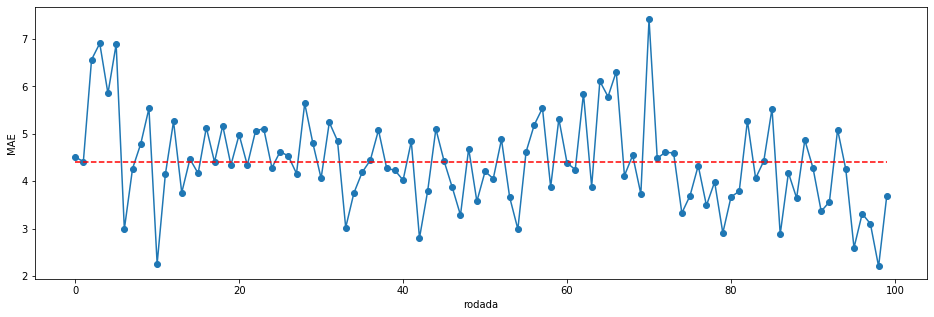

In [137]:
fig = plt.figure(figsize = (16, 5)
                )
plt.plot(a, 'o-')
plt.plot(np.repeat(np.array(a).mean(), len(a)), 
         'r--'
        )
plt.xlabel('rodada')
plt.ylabel('MAE');

#### E comparar com a distribuição dos valores da variável resposta da base

In [138]:
df['MEDV'].describe()

count    100.000000
mean      22.185000
std        9.137086
min        5.600000
25%       17.075000
50%       20.550000
75%       23.825000
max       50.000000
Name: MEDV, dtype: float64

#### Pelo gráfico gerado acima, podemos ver que o MAE obtido pelos modelos chega a ser tão alto quanto 7 unidades, que é  próximo do desvio padrão da própria distribuição do conjunto! Ou seja, a performance do modelo é bastante instável para termos uma solução aceitável. 

#### Porém, se tivessemos limitado nosso estudo a pegar somente o primeiro resultado de validação esterna deste conjunto, possívelmente poderiamos ter sido enganados por um valor baixo de MAE, que nos indicaria um 'bom modelo' para aplicação.

#### Finalmente, para responder a segunda pergunta, podemos observar novamente a distribuição do conjunto de dados inicial

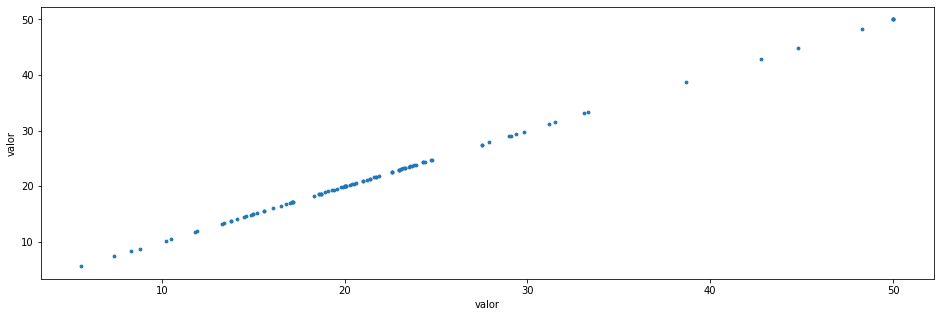

In [139]:
fig = plt.figure(figsize = (16, 5)
                )
plt.scatter(df['MEDV'], 
            df['MEDV'], 
            s = 8
           )
plt.xlabel('valor')
plt.ylabel('valor');

#### Nesta distribuição de valores de casas (MEDV), podemos observar uma escasses de observações em certas regiões. Como discutido em sala de aula (ver slides), esta situação pode explicar em uma grande variação na performance do modelo pelo fato de que ao selecionarmos aleatoriamente o conjunto teste e treino, podemos gerar distribuições muito distintas. 

##### Este fato faz com que, por exemplo, algumas amostras no conjunto teste não possuam um representante similar no conjunto treino. Em outras palavras, podemos gerar distribuições no conjunto treino que não são representativas da distribuição inicial.

## Validação Cruzada

#### Uma forma de obter uma estimativa de performance mais realista do modelo na predição da variável resposta em novas observações é a validação cruzada. Este método consiste em separar o conjunto treino em diversos subconjuntos treinos menores e rodar vários modelos alternando o papel dos subconjuntos como parte do treino ou como um conjunto teste interno (ver slides da aula). A validação cruzada permite avaliar a estabilidade e capacidade de generalização do modelo proposto.

#### Na etapa anterior, ao executar o modelo diversas vezes e obter uma estimativa da variação de performance e da performance média, já realizamos o tipo mais simples de validação externa: Sub-amostragem Repetitiva Aleatória. Este método consiste em selecionar aleatoriamente subconjuntos treino e teste e avaliar a performance de forma iterativa. Porém, como aprendemos em sala de aula, uma forma mais eficiente de validação cruzada consiste em separar o conjunto treino em K conjuntos de tamanhos iguais e avaliar a performance em todas as permutações possíveis, em um processo conhecido como K-fold (ver slides da aula).

#### Para avaliar o modelo utilizando o método K-fold, podemos inicialmente quebrar o conjunto de dados em treino e teste. Ao conjunto teste que não entrará no processo de validação cruzada podemos dar o nome de conjunto Hold-Out.

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['MEDV'], axis=1), 
                                                    df['MEDV'], 
                                                    test_size = 0.2, 
                                                    random_state = 0
                                                   )

Podemos então importar a função cross_val_score implementada no scikitlearn para gerar a análise de validação cruzada

In [141]:
from sklearn.model_selection import cross_val_score

#### E definir a função para executar este processo. Por consistência, continuaremos com a métrica de erro médio absoluto (MAE).

In [142]:
def run_cv(X_train, y_train, k):
    model = DecisionTreeRegressor()
    
    score = cross_val_score(model, 
                            X_train, 
                            y_train, 
                            scoring = 'neg_mean_absolute_error', 
                            cv = k
                           )
    return score*-1

#### Vamos então gerar a analizar uma lista de resultados de performance para cada combinação do K-fold.

#### Primeiramente, quebrando a base de treino em 20 subconjuntos (K=20)

In [143]:
score20 = run_cv(X_train, y_train, 20)
print('mean', score20.mean())
print('std', score20.std())

mean 5.25375
std 2.706846354616383


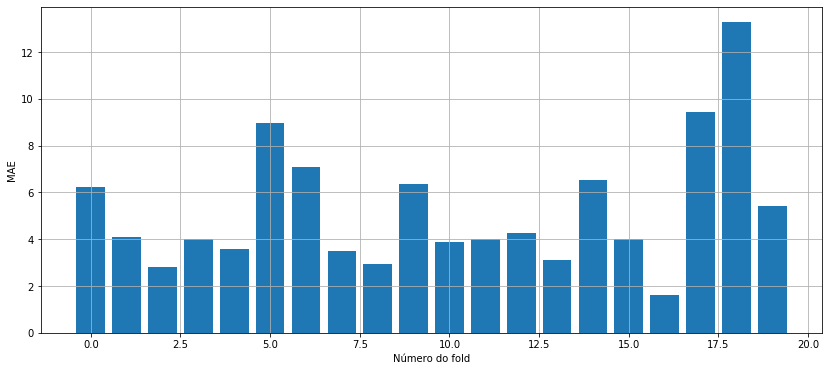

In [144]:
fig = plt.figure(figsize = (14,6))
plt.bar(range(len(score20)), 
        score20
       )
plt.grid()
plt.xlabel('Número do fold')
plt.ylabel('MAE');

#### Podemos observar uma grande variação nos valores de MAE obtidos para cada rodada. Isso significa que nosso modelo é muito instável. Como discutido em sala de aula, uma forma de aumentar a estabilidade de conjuntos de dados com baixa redundância é reduzir o número de K, aumentando o tamanho de cada subconjunto e maximizando a chance de ambos possuirem dados representativos em todas as regiões. Este processo um balanço entre aumento da estabilidade do modelo pela redução do K e diminuição da performance geral dos conjuntos treinos do K-fold, uma vez o total de amostras nos conjuntos treinos passa a ser menor.

#### Vamos testar a validação cruzada com k=10

In [145]:
score10 = run_cv(X_train, 
                 y_train, 
                 10
                )
print('mean', score10.mean())
print('std', score10.std())

mean 5.0575
std 1.9368321429592188


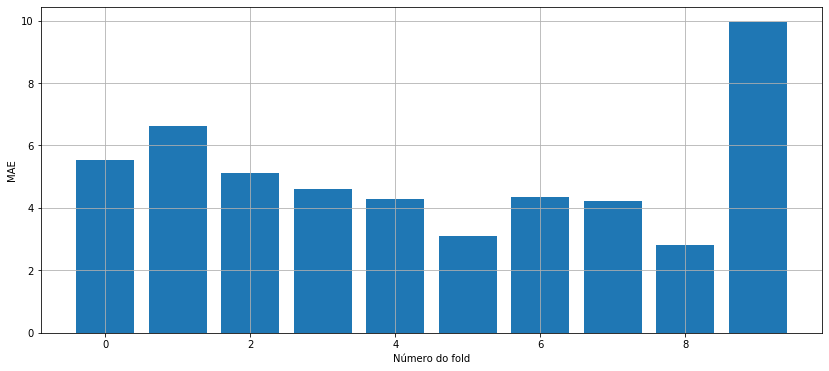

In [146]:
fig = plt.figure(figsize = (14,6)
                )
plt.bar(range(len(score10)), 
        score10
       )
plt.grid()
plt.xlabel('Número do fold')
plt.ylabel('MAE');

#### Testemos para $k = 5$.

In [147]:
score5 = run_cv(X_train, 
                y_train, 
                5
               )
print('mean', score5.mean())
print('std', score5.std())

mean 4.4925
std 1.2021946077902699


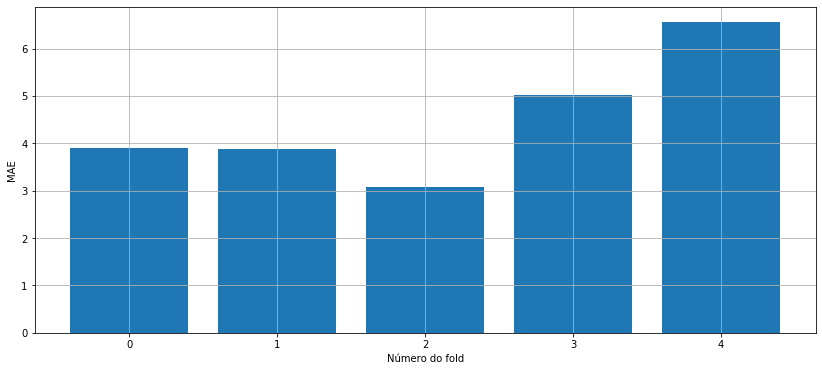

In [148]:
fig = plt.figure(figsize = (14,6)
                )
plt.bar(range(len(score5)), 
        score5
       )
plt.grid()
plt.xlabel('Número do fold')
plt.ylabel('MAE');

#### E reduzir mais ainda para $k = 2$.

In [149]:
score2 = run_cv(X_train, 
                y_train, 
                2
               )
print('mean', score2.mean())
print('std', score2.std())

mean 5.1525
std 0.43000000000000105


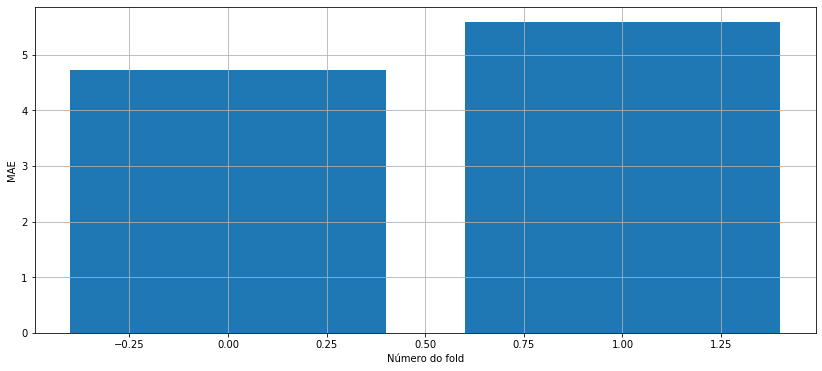

In [150]:
fig = plt.figure(figsize = (14,6) )
plt.bar(range(len(score2)), 
        score2
       )
plt.grid()
plt.xlabel('Número do fold')
plt.ylabel('MAE');

#### Podemos então comparar o desvio médio padrão (std) nas performances em cada valor de `k-fold`.

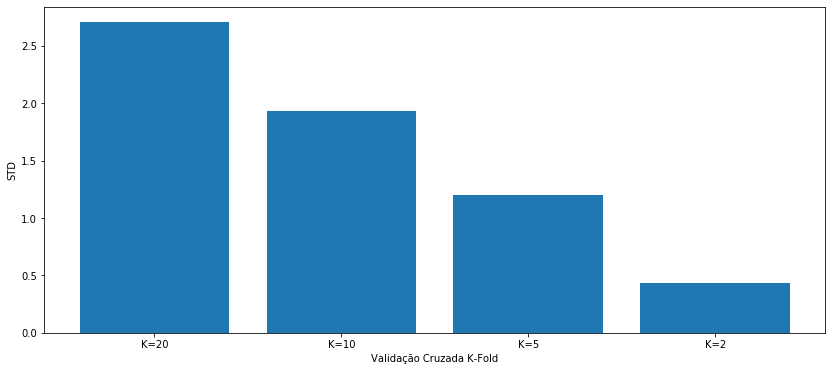

In [151]:
fig = plt.figure(figsize=(14,6))
plt.bar(range(4), [score20.std(),
                   score10.std(),
                   score5.std(),
                   score2.std()]);
plt.xticks(range(4), ('K=20', 'K=10', 'K=5', 'K=2')
          )
plt.xlabel('Validação Cruzada K-Fold')
plt.ylabel('STD');

#### Observando o gráfico acima, podemos notar que a partir da variação de performance na análise de K-fold para diferentes valores de K podemos encontrar a faixa de K em que o modelo apresenta a maior estabilidade possível dentro e ter uma ideia mais realista das limitações do modelo e do conjunto de dados para a construção de modelos preditivos 

## Leave-One-Out (LOO)

#### Além de ser uma ferramenta poderosa para avaliar a estabilidade dos modelos preditivos, outra aplicação bastante útil da validação cruzada é a identificação de outliers no conjunto de dados. Ao ajustarmos o número de folds (o valor de K) para o número de elementos no conjunto, podemos identificar quais observações são mais difíceis de serem preditas pelo modelo quando as mesmas se encontram como conjunto teste na validação cruzada. 

#### O fato destas observações apresentarem um erro grande de predição pode ter como origem uma baixa sua baixíssima representatividade na distribuição de valores da variável resposta (talvez um erro de medida?) ou em uma região específica da distribuição de features.

#### Para tentarmos identificar outliers no nosso conjunto de dados, vamos utilizar a função que construímos (run_cv) para computar os erros de predição para um K-fold com valor de K correspondendo ao número de observações no nosso conjunto.

In [152]:
score_LOO = run_cv(X_train, y_train, X_train.shape[0])

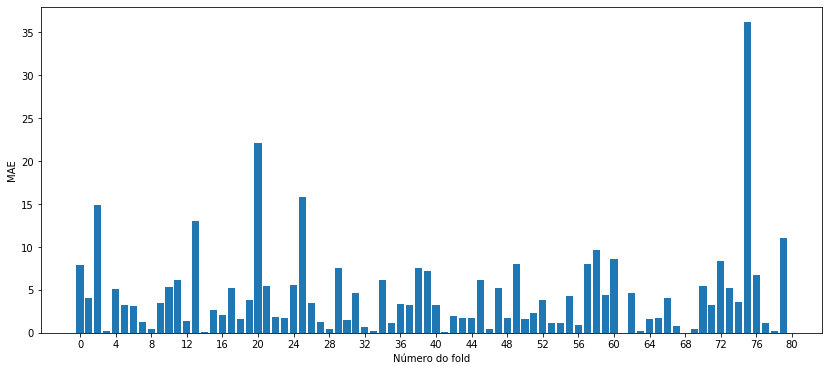

In [153]:
fig = plt.figure(figsize = (14,6)
                )
plt.bar(range(len(score_LOO)), 
        score_LOO
       )
plt.xticks(np.arange(0, len(score_LOO)+1 , 4.0)
          )
plt.xlabel('Número do fold')
plt.ylabel('MAE');

#### A partir do gráfico acima mostrando os erros de predição para cada uma das observações como conjunto teste, podemos selecionar os folds com maior erro e identificar os valores de MEDV da variável resposta. No gráfico apresentado acima, os folds de maior erro de predição (maior MAE) são os folds 20 e 75

#### Podemos gerar um novo conjunto treino excluindo estes 2 casos com MAE acima de 20 unidades.

In [154]:
X_train_filtered = X_train.iloc[np.where(score_LOO < 20)]
y_train_filtered = y_train.iloc[np.where(score_LOO < 20)]

In [155]:
print('Observações da base original:', y_train.shape[0])
print('Observações da base filtrada:', y_train_filtered.shape[0])

Observações da base original: 80
Observações da base filtrada: 78


#### Finalmente, a fim de avaliar o efeito destes potenciais outliers nos modelos preditivos, podemos executar novamente nosso estudo inicial com a funcão run_cv e comparar a performance média na presença ou ausência destas observações selecionadas

In [156]:
with_outliers = []
for i in range(100):
    with_outliers.append(run_cv(X_train, 
                                y_train, 10)
                        )
print('MAE para o conjunto original: %1.4f' % np.array(with_outliers).mean())
print('STD para o conjunto original: %1.4f' % np.array(with_outliers).std())

MAE para o conjunto original: 4.7627
STD para o conjunto original: 1.6117


In [157]:
no_outliers = []
for i in range(100):
    no_outliers.append(run_cv(X_train_filtered, 
                              y_train_filtered, 
                              10
                             )
                      )
print('MAE para o conjunto filtrado: %1.4f' % np.array(no_outliers).mean())
print('STD para o conjunto filtrado: %1.4f' % np.array(no_outliers).std())

MAE para o conjunto filtrado: 4.0477
STD para o conjunto filtrado: 1.3067


#### Comparando os resultados acima, podemos ver que a remoção de apenas 2 observações identificadas pelo método Leave-One-Out como possíveis outliers permite obtermos um modelo com melhor performance (menor MAE) e estabilidade (menor STD).

## Estratificação

#### Como vimos em sala de aula, a quebra de uma base de forma aleatória pode levar a sub-conjuntos com distribuições muito diferentes, principalmente quando a base de dados é escassa. 

#### Uma forma eficiente de tentarmos evitar este problema é a estratificação, que busca separar os subconjuntos da forma mais homogênea possível, com base em uma variável resposta (veja slides da aula).

#### Estratificação: dividir o dataset em subgrupos homogêneos entre si, de forma a maximizar a similaridade das distribuições dos subconjuntos à distribuição do conjunto original.

##### Para separar subconjuntos, os métodos de estratificação distribuiem grupos de observações com a mesma variável resposta de forma a equilibrar os subconjuntos finais. Este método é bastante prático quando aplicado a problemas de classificação, em que as próprias categorias podem ser utilizadas como critério para construir os sub-conjuntos. 

#### Como o problema que enfrentamos neste estudo é um caso de regressão com uma variável resposta contínua, uma alternativa para aplicar o método de estratificação é gerar uma nova variável resposta segmentada por faixas de valores e utiliza-la como índice para agrupar a variável e finalmente gerarmos subconjutos balanceados.

#### Podemos testar esta estratégia na base original, para separar os conjuntos treino e teste 

In [158]:
df['FAIXA_VALOR'] = df['MEDV'].astype('O')

df.loc[(df['MEDV'] <= 20), 
       'FAIXA_VALOR'] = 'baixo'

df.loc[(df['MEDV'] > 20), 
       'FAIXA_VALOR'] = 'alto'

# df.loc[(df['MEDV']<=10), 'FAIXA_VALOR'] = 'muito-baixo'
# df.loc[(df['MEDV']>10) & (df['MEDV']<=20), 'FAIXA_VALOR'] = 'baixo'
# df.loc[(df['MEDV']>20) & (df['MEDV']<=30), 'FAIXA_VALOR'] = 'medio'
# df.loc[(df['MEDV']>30) & (df['MEDV']<40), 'FAIXA_VALOR'] = 'alto'
# df.loc[(df['MEDV']>=40), 'FAIXA_VALOR'] = 'muito-alto'

In [159]:
df['FAIXA_VALOR'].value_counts()

alto     55
baixo    45
Name: FAIXA_VALOR, dtype: int64

#### Partindo desta nova segmentação da distribuição da variável resposta, podemos comparar a performance dos modelos gerados no inicio desta prática (com a função pred_value) com a performance obtida incluindo a etapa de estratificação na construção dos conjuntos de dados.

#### Incluindo a opção de estratificação na função inicial `'pred_price'`.

In [160]:
def pred_price_strat(df, strat_label=None):
    # separando o conjunto total em conjunto treino e teste
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['MEDV'], axis = 1),
                                                        df['MEDV'],
                                                        test_size = -.3,
                                                        stratify = strat_label, 
                                                        random_state = 0
                                                       )
    # definindo o modelo
    model = DecisionTreeRegressor()
    # otimizando os hiperparâmetros do modelo
    model.fit(X_train, y_train)
    # avaliando o modelo gerado
    y_pred = model.predict(X_test)
    return metrics.mean_absolute_error(y_test, y_pred)

#### Rodando os modelos sem estratificação.

In [161]:
no_strat = []
with_strat = []
for i in range(100):
    no_strat.append(pred_price_strat(df.drop('FAIXA_VALOR', axis = 1)
                                    )
                   )
    
    with_strat.append(pred_price_strat(df.drop('FAIXA_VALOR', axis = 1), 
                                       df['FAIXA_VALOR'].values
                                      )
                     )

ValueError: test_size=-0.3 should be either positive and smaller than the number of samples 100 or a float in the (0, 1) range

#### Podemos comparar o desvio padrão dos valores de MAE para cada caso.

In [ ]:
np.array(no_strat).std()

In [ ]:
np.array(with_strat).std()

#### E plotar os gráficos de cada conjunto de predições.

In [ ]:
fig = plt.figure(figsize = (14,6))

plt.plot(range(len(no_strat)), 
         no_strat, 
         c = 'k', 
         label = "no stratification"
        )
plt.plot(range(len(with_strat)), 
         with_strat, 
         c = 'r', 
         label = "with stratification"
        )
plt.legend()
plt.xlabel('run')
plt.ylabel('MAE');

#### E finalmente, podemos observar que adicionar a opção de estratificação os modelos gerados permite reduzir a instabilidade dos modelos.